# Community Model
We want to combine all 7 bacterial species into one big community model, where bacteria exchange metabolites. This is important to analyse how they interact which each other reagrding e.g. cross-feeding

# Imports and Load Individual Models

In [1]:
# basic
import pandas as pd
import numpy as np
import os
import re
# cobra & micom
from cobra.io import read_sbml_model, write_sbml_model
from cobra.flux_analysis import flux_variability_analysis, pfba
from cobra.medium import minimal_medium
from cobra.exceptions import Infeasible
from micom import Community
from micom.workflows import tradeoff
# plot
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import seaborn as sns

In [2]:
# Load SBML Models
models_path = "/home/lisa/Dokumente/Programmierung/Models/10_duplicate_removal/"
models = {}
for model_name in (f for f in os.listdir(models_path) if f.endswith(".xml")):
    model = read_sbml_model(f"{models_path}/{model_name}")
    model.solver = "cplex"
    name = str(model_name[:3])
    models[name] = model

models = {key: models[key] for key in sorted(models.keys())}  # sorts the dictionary alphabetically
AA1, AA2, AA3, AA4, AA5, AA6, AA7 = [models[f"AA{i}"] for i in range(1, 8)]

Restricted license - for non-production use only - expires 2026-11-23


In [5]:
def get_amounts(model):
    rxns = len(model.reactions)
    mets = len(model.metabolites)
    print(f"{model.id} has {rxns} reactions and {mets} metabolites")

In [7]:
for model in models.values():
    get_amounts(model)

AA1 has 2261 reactions and 1513 metabolites
AA2 has 2669 reactions and 1789 metabolites
AA3 has 2223 reactions and 1501 metabolites
AA4 has 2795 reactions and 1758 metabolites
AA5 has 2107 reactions and 1446 metabolites
AA6 has 2578 reactions and 1685 metabolites
AA7 has 2522 reactions and 1655 metabolites


In [51]:
AA1.reactions.query("Growth")

[<Reaction Growth at 0x77979a6b3700>]

# Functions

In [29]:
def safe_parse(x):
    if x.startswith('['):
        # Add quotes around items inside brackets if they're not already quoted
        items = re.findall(r'\w+__?\w*', x)
        return items
    else:
        return x


# change medium
def change_medium(model, medium_dict):
    # when I read the csv files with medium info it is saved as a dataframe, but i want a dict
    if isinstance(medium_dict, pd.DataFrame):
        medium_dict = dict(zip(medium_dict.reaction, medium_dict.bound))

    if model.id == "C7":
        medium_dict = {k.removesuffix('_e') + '_m' if k.endswith('_e') else k: v for k, v in medium_dict.items()}

    # Only include reactions that are in the model
    valid_medium = {
        rxn: bound for rxn, bound in medium_dict.items()
        if rxn in model.reactions
    }
    model.medium = valid_medium
    #print(valid_medium)


# changes medium, does pfba and returns growth rate
def test_medium(model, medium_dict):
    with model:
        change_medium(model, medium_dict)
        try:
            #print(model.medium)
            solution = pfba(model)
            if model.id != "C7":
                growth = solution.fluxes["Growth"]
            else:
                growth = solution.fluxes[solution.fluxes.index.str.contains('Growth')]
            return growth
        except Infeasible:
            return None


# takes result dict from "create medium" to create a heatmap
def visualise_heatmap_medium(results):
    # Convert the results dictionary to a DataFrame
    df = pd.DataFrame(results).T  # Transpose the DataFrame

    # Create a heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(df, annot=True, cmap="YlOrRd", cbar_kws={'label': 'Growth Value'})
    plt.title("Growth Values Heatmap")
    plt.xlabel("Model ID")
    plt.ylabel("Carbon Source")
    plt.show()


# takes a list with different carbon sources (EX reactions) and a list with reactions that together form a minimal medium
# each carbon source is coupled with the minimal medium one at the time and these media are then testes for growth
# model_dict contain the models where the media are tested on;
# it is visualised through a heatmap
def create_medium(carbon_list, minimal_list, model_dict, medium_uptake_bound, carbon_only = False):
    # Flatten the carbon_list for consistent keys
    flattened_sources = [item[0] if isinstance(item, list) else item for item in carbon_list]
    results = {carbon[3:-2]: {model.id: None for model in model_dict.values()} for carbon in flattened_sources}

    for carbon in carbon_list:
        # Standardize the carbon key (used to index the results dict)
        if isinstance(carbon, list):
            carbon_key = carbon[0][3:-2]
            new_medium = minimal_list + carbon
        else:
            carbon_key = carbon[3:-2]
            new_medium = minimal_list + [carbon]

        # define uptake bound here (this has big impact on how much biomass can be produced)
        # med_dict = {new_medium[i]: medium_uptake_bound for i in range(len(new_medium))}

        #####
        if carbon_only:
            # Ensure carbon is always a list for uniform membership check
            carbon_sources = carbon if isinstance(carbon, list) else [carbon]

            med_dict = {
                met: medium_uptake_bound if met in carbon_sources else 1000
                for met in new_medium}
        else:
            med_dict = {met: medium_uptake_bound for met in new_medium}
        #####

        for model in model_dict.values():
            growth_val = test_medium(model, med_dict)
            # print(growth_val)
            if isinstance(growth_val, pd.Series):
                print(carbon, growth_val)
                growth_val = sum(pd.DataFrame(growth_val)["fluxes"])/7
            results[carbon_key][model.id] = growth_val
        #print("-----")

    visualise_heatmap_medium(results)

# Create Community Model
we want to combine our 7 models into one; they'll share one compartment where they can exchange metabolites.

## MICOM

with A7; if you run everything without changes we'll get infeasible flux solution; only if I change all lower bounds of all EXchange reactions to -1000 then we get a feasible solution (MICOM changed the lower bounds for all EX reactions that go from a bacterium into the medium to -100)

in comparison i tried the whole community model creation without AA7 and there it works directly without changing anything

In [3]:
taxonomy = pd.read_csv("../Datasets/community_model.csv", sep=";")
taxonomy

,id,genus,species,reactions,metabolites,file,abundance
0,AA1,Stenotrophomonas,Stenotrophomonas maltophilia,2261,1513,/home/lisa/Dokumente/Programmierung/Models/10_...,16
1,AA2,Brucella,Brucella pituitosa,2669,1789,/home/lisa/Dokumente/Programmierung/Models/10_...,5
2,AA3,Curtobacterium,Curtobacterium pusillum,2223,1501,/home/lisa/Dokumente/Programmierung/Models/10_...,8
3,AA4,Enterobacter,Enterobacter ludwigii,2795,1758,/home/lisa/Dokumente/Programmierung/Models/10_...,65
4,AA5,Chryseobacterium,Chryseobacterium indologenes,2107,1446,/home/lisa/Dokumente/Programmierung/Models/10_...,1
5,AA6,Herbaspirillum,Herbaspirillum robiniae,2578,1685,/home/lisa/Dokumente/Programmierung/Models/10_...,2
6,AA7,Pseudomonas,Pseudomonas putida,2522,1655,/home/lisa/Dokumente/Programmierung/Models/10_...,3


I talked with Nadine in my meeting on the 06 June and we decided that at the beginning we're not going to use abundances

In [4]:
# without abundance
syncom = Community(taxonomy.iloc[:, :-1], name="synthetic seven member bacterial community", id="C7", solver="cplex")

Output()

In [3]:
#syncom = Community(taxonomy, name="synthetic seven member bacterial community", id="C7", solver="cplex")

Restricted license - for non-production use only - expires 2026-11-23


Output()

In [ ]:
# TODO: use different abundancies and check if biomass is different and especially check if bounds of EX reactions changed

In [74]:
syncom_EX = syncom.reactions.query("^EX_")
print(f"My syncom has in total {len(syncom_EX)} EX reactions.")

My syncom has in total 2571 EX reactions.


In [72]:
total_EX = 0
for model in models.values():
    EX = [rxn.id for rxn in model.reactions if rxn.id.startswith("EX_")]
    total_EX += len(EX)
    print(f"Model {model.id} has {len(EX)} EX reactions.")
print(f"That means there are in total {total_EX} EX reactions in my 7 models.")

syncom_nonM_EX = [rxn for rxn in syncom.reactions.query("^EX_") if not rxn.id.endswith("m")]
print(f"There are {len(syncom_nonM_EX)} EX reactions from my models into shared medium in the syncom.")

Model AA1 has 253 EX reactions.
Model AA2 has 287 EX reactions.
Model AA3 has 280 EX reactions.
Model AA4 has 383 EX reactions.
Model AA5 has 251 EX reactions.
Model AA6 has 282 EX reactions.
Model AA7 has 287 EX reactions.
That means there are in total 2023 EX reactions in my 7 models.
There are 2021 EX reactions from my models into shared medium in the syncom.


In [76]:
all_EX = set()
for model in models.values():
    EX = [rxn.id for rxn in model.reactions if rxn.id.startswith("EX_")]
    all_EX.update(EX)
print(f"There are {len(all_EX)} unique EX reactions in my 7 models.", )

EX_syncom_m = [rxn for rxn in syncom.reactions.query("^EX_") if rxn.id.endswith("m")]
print(f"There are {len(EX_syncom_m)} EX reactions from/into _m in my syncom.", )

There are 553 unique EX reactions in my 7 models.
There are 550 EX reactions from/into _m in my syncom.


In [80]:
trimmed_all_EX = {s[:-2] for s in all_EX}  # assuming all_EX is a set of strings
trimmed_EX_syncom_m = {rxn.id[:-2] for rxn in EX_syncom_m}  # handle Reaction objects

diff = trimmed_all_EX - trimmed_EX_syncom_m
diff

{'EX_acon_C', 'EX_acysbmn', 'EX_bmn', 'EX_glcn__D'}

In [81]:
diff = trimmed_EX_syncom_m - trimmed_all_EX
diff

{'EX_acon'}

In [87]:
syncom.reactions.query("EX_acon_C")

[<Reaction EX_acon_C_e__AA2 at 0x71f3288aec20>,
 <Reaction EX_acon_C_e__AA4 at 0x71f321db7d30>,
 <Reaction EX_acon_C_e__AA6 at 0x71f321da3ee0>,
 <Reaction EX_acon_C_e__AA7 at 0x71f31dd53f70>]

In [12]:
for rxn in syncom.reactions.query("^EX_"):
    print(rxn.id[len(rxn.id)-3:], rxn.lower_bound)

AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000
AA1 -1000


### change bound of EX reactions

In [5]:
# change lower bound of Exchange reactions (EX between bacteria and medium)
for rxn in syncom.reactions.query("^EX_"):
    rxn.lower_bound = -1000

In [169]:
syncom.optimize(pfba=True)

,abundance,growth_rate,reactions,metabolites
compartments,,,,
AA1,0.142857,32.984841,2261,1513
AA2,0.142857,55.623791,2668,1788
AA3,0.142857,32.712064,2222,1500
AA4,0.142857,85.483319,2795,1757
AA5,0.142857,46.797803,2107,1446
AA6,0.142857,67.002098,2578,1685
AA7,0.142857,55.322197,2521,1654
medium,NaN,NaN,550,550


In [113]:
syncom.cooperative_tradeoff()

,abundance,growth_rate,reactions,metabolites
compartments,,,,
AA1,0.142857,32.984842,2261,1513
AA2,0.142857,47.495101,2668,1788
AA3,0.142857,31.586607,2222,1500
AA4,0.142857,76.936697,2795,1757
AA5,0.142857,46.797803,2107,1446
AA6,0.142857,67.002099,2578,1685
AA7,0.142857,53.859039,2521,1654
medium,NaN,NaN,550,550


In [5]:
syncom

Name,C7
Memory address,78a87a6f3460
Number of metabolites,11894
Number of reactions,17702
Number of genes,8726
Number of groups,0
Objective expression,1.0*community_objective
Compartments,"C_e__AA1, C_p__AA1, C_c__AA1, m, C_e__AA2, C_p__AA2, C_c__AA2, C_e__AA3, C_p__AA3, C_c__AA3, C_e__AA4, C_p__AA4, C_c__AA4, C_e__AA5, C_p__AA5, C_c__AA5, C_e__AA6, C_p__AA6, C_c__AA6, C_e__AA7, C_p__AA7, C_c__AA7"


In [43]:
syncom.medium

{'EX_14glucan_m': 1000.0,
 'EX_2ddglcn_m': 1000.0,
 'EX_2dhglcn_m': 1000.0,
 'EX_2m35mdntha_m': 1000.0,
 'EX_35dnta_m': 1000.0,
 'EX_3mb_m': 1000.0,
 'EX_3oxoadp_m': 1000.0,
 'EX_4abut_m': 1000.0,
 'EX_4abutn_m': 1000.0,
 'EX_4hbz_m': 1000.0,
 'EX_5drib_m': 1000.0,
 'EX_6apa_m': 1000.0,
 'EX_6atha_m': 1000.0,
 'EX_LalaDgluMdapDala_m': 1000.0,
 'EX_LalaLglu_m': 1000.0,
 'EX_R_3h4atba_m': 1000.0,
 'EX_R_3hhpa_m': 1000.0,
 'EX_R_3hpba_m': 1000.0,
 'EX_R_3hpdeca_m': 1000.0,
 'EX_R_3hphpa_m': 1000.0,
 'EX_R_3hpnona_m': 1000.0,
 'EX_R_3hpocta_m': 1000.0,
 'EX_ac_m': 1000.0,
 'EX_acac_m': 1000.0,
 'EX_acald_m': 1000.0,
 'EX_acgam_m': 1000.0,
 'EX_acmana_m': 1000.0,
 'EX_actn__R_m': 1000.0,
 'EX_ade_m': 1000.0,
 'EX_adn_m': 1000.0,
 'EX_agm_m': 1000.0,
 'EX_akg_m': 1000.0,
 'EX_ala_B_m': 1000.0,
 'EX_ala_L_asp__L_m': 1000.0,
 'EX_ala_L_glu__L_m': 1000.0,
 'EX_ala_L_thr__L_m': 1000.0,
 'EX_ala__D_m': 1000.0,
 'EX_ala__L_m': 1000.0,
 'EX_ala_gln_m': 1000.0,
 'EX_ala_his_m': 1000.0,
 'EX_ala_leu_

### without A7

In [6]:
# only using model 1-6 works
smoll_com = Community(pd.read_csv("../Datasets/smoll_community_model.csv", sep=";"), name="uwu", id="smoll", solver="cplex")

Output()

In [7]:
smoll_com.optimize()

,abundance,growth_rate,reactions,metabolites
compartments,,,,
AA2,0.2,31.554726,2668,1788
AA3,0.2,15.995017,2222,1500
AA4,0.2,68.541402,2795,1758
AA5,0.2,35.282231,2107,1446
AA6,0.2,37.586852,2578,1685
medium,NaN,NaN,514,514


In [8]:
smoll_com.cooperative_tradeoff()

,abundance,growth_rate,reactions,metabolites
compartments,,,,
AA2,0.2,31.554726,2668,1788
AA3,0.2,15.995017,2222,1500
AA4,0.2,68.541402,2795,1758
AA5,0.2,35.282231,2107,1446
AA6,0.2,37.586852,2578,1685
medium,NaN,NaN,514,514


### Micom Test Data

In [92]:
from micom.data import test_taxonomy

taxonomy_test = test_taxonomy()
taxonomy_test

,id,genus,species,reactions,metabolites,file
0,Escherichia_coli_1,Escherichia,Escherichia coli,95,72,/home/lisa/miniconda3/envs/MA/lib/python3.10/s...
1,Escherichia_coli_2,Escherichia,Escherichia coli,95,72,/home/lisa/miniconda3/envs/MA/lib/python3.10/s...
2,Escherichia_coli_3,Escherichia,Escherichia coli,95,72,/home/lisa/miniconda3/envs/MA/lib/python3.10/s...
3,Escherichia_coli_4,Escherichia,Escherichia coli,95,72,/home/lisa/miniconda3/envs/MA/lib/python3.10/s...


In [93]:
from micom import Community

com = Community(taxonomy_test)

Output()

In [94]:
from micom.data import test_db
from micom.data import test_data

data = test_data()
data

'/home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/data/artifacts/species_models.qza'

In [99]:
taxonomy = pd.read_csv("../Datasets/community_model_build.csv", sep=";")

In [100]:
from micom.workflows import build
manifest = build(taxonomy=taxonomy, out_folder="../", cutoff=0.0001, threads=2, model_db=None, solver="cplex")

Output()

Restricted license - for non-production use only - expires 2026-11-23


In [110]:
mre_jin = pd.read_csv("../Datasets/Medium/medium_ARE_Jin.csv", sep=";")

In [111]:
medium_mre_m9 = pd.concat([m9, mre_jin], ignore_index=True)

In [112]:
from micom.workflows import grow
res = grow(manifest, model_folder="../", medium=medium_mre_m9, tradeoff=0.5, threads=2)

Output()

[06/23/25 15:30:00] WARNING  solver encountered an error         ]8;id=99130;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py\solution.py]8;;\:]8;id=585237;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py#206\206]8;;\
                             infeasible                                         
[06/23/25 15:30:01] WARNING  solver encountered an error         ]8;id=182918;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py\solution.py]8;;\:]8;id=814773;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py#206\206]8;;\
                             infeasible                                         
                    ERROR    Could not solve cooperative tradeoff for ]8;id=412366;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/workflows/grow.py\grow.py]8;;\:]8;id=127351;file:///home/lisa/miniconda3/envs/MA/lib/

OptimizationError: All numerical optimizations failed. This indicates a problem with the solver or numerical instabilities. Check that you have CPLEX or Gurobi installed. You may also increase the abundance cutoff to create simpler models.

In [27]:
print(com.objective.expression)
com.optimize()

1.0*community_objective


,abundance,growth_rate,reactions,metabolites
compartments,,,,
Escherichia_coli_1,0.25,0.000000,95,72
Escherichia_coli_2,0.25,0.000000,95,72
Escherichia_coli_3,0.25,0.000000,95,72
Escherichia_coli_4,0.25,3.495686,95,72
medium,NaN,NaN,20,20


In [28]:
sol = com.cooperative_tradeoff(fraction=1.0)
sol

,abundance,growth_rate,reactions,metabolites
compartments,,,,
Escherichia_coli_1,0.25,0.873922,95,72
Escherichia_coli_2,0.25,0.873922,95,72
Escherichia_coli_3,0.25,0.873922,95,72
Escherichia_coli_4,0.25,0.873922,95,72
medium,NaN,NaN,20,20


In [31]:
com

Name,None
Memory address,77977c5541f0
Number of metabolites,308
Number of reactions,400
Number of genes,137
Number of groups,0
Objective expression,1.0*community_objective
Compartments,"c__Escherichia_coli_1, e__Escherichia_coli_1, m, c__Escherichia_coli_2, e__Escherichia_coli_2, c__Escherichia_coli_3, e__Escherichia_coli_3, c__Escherichia_coli_4, e__Escherichia_coli_4"


## PyCoMo
wir bleiben bei MICOM, da das mehr etabliert ist

In [9]:
from pathlib import Path
import sys
import cobra
import os

In [10]:
path_root = "/home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/pycomo-0.2.8.dist-info"
sys.path.append(path_root)
import pycomo
pycomo.configure_logger(level="INFO")

2025-06-05 14:18:17,676 - pycomo - INFO - Logger initialized.
2025-06-05 14:18:17,689 - pycomo - INFO - Process Pool Logger initialized.
2025-06-05 14:18:17,690 - pycomo - INFO - Utils Logger initialized.
2025-06-05 14:18:17,693 - pycomo - INFO - Multiprocess Logger initialized.
2025-06-05 14:18:17,694 - pycomo - INFO - Log level set to INFO


In [11]:
test_model_dir = "../Models/10_duplicate_removal"
# needed to change solver to cplex
named_models = pycomo.load_named_models_from_dir(test_model_dir)

In [23]:
for model in named_models.values():
    print(model.objective)

Maximize
1.0*Growth - 1.0*Growth_reverse_699ae
Maximize
1.0*Growth - 1.0*Growth_reverse_699ae
Maximize
1.0*Growth - 1.0*Growth_reverse_699ae
Maximize
1.0*Growth - 1.0*Growth_reverse_699ae
Maximize
1.0*Growth - 1.0*Growth_reverse_699ae
Maximize
1.0*Growth - 1.0*Growth_reverse_699ae
Maximize
1.0*Growth - 1.0*Growth_reverse_699ae


In [12]:
single_org_models = []
for name, model in named_models.items():
    print(name)
    single_org_model = pycomo.SingleOrganismModel(model, name)
    single_org_models.append(single_org_model)

AA3_deleted_duplicates
AA5_deleted_duplicates
AA2_deleted_duplicates
AA7_deleted_duplicates
AA4_deleted_duplicates
AA1_deleted_duplicates
AA6_deleted_duplicates


In [13]:
community_name = "lisas_endless_pain"
com_model_obj = pycomo.CommunityModel(single_org_models, community_name)

In [14]:
com_model_obj.model

2025-06-05 14:19:49,151 - pycomo - INFO - No community model generated yet. Generating now:
2025-06-05 14:19:49,323 - pycomo - INFO - Identified biomass reaction from objective: Growth
2025-06-05 14:19:49,323 - pycomo - INFO - Note: no products in the objective function, adding biomass to it.
2025-06-05 14:19:54,552 - pycomo - INFO - Identified biomass reaction from objective: Growth
2025-06-05 14:19:54,552 - pycomo - INFO - Note: no products in the objective function, adding biomass to it.
2025-06-05 14:20:02,326 - pycomo - INFO - Identified biomass reaction from objective: Growth
2025-06-05 14:20:02,326 - pycomo - INFO - Note: no products in the objective function, adding biomass to it.
2025-06-05 14:20:13,667 - pycomo - INFO - Identified biomass reaction from objective: Growth
2025-06-05 14:20:13,668 - pycomo - INFO - Note: no products in the objective function, adding biomass to it.
2025-06-05 14:20:24,384 - pycomo - INFO - Identified biomass reaction from objective: Growth
2025-06

Name,lisas_endless_pain
Memory address,78a8fe5ae1a0
Number of metabolites,35552
Number of reactions,41361
Number of genes,8734
Number of groups,0
Objective expression,1.0*community_biomass - 1.0*community_biomass_reverse_44dc1
Compartments,"AA3_deleted_duplicates_C_c, AA3_deleted_duplicates_C_p, AA3_deleted_duplicates_C_e, AA3_deleted_duplicates_medium, medium, fraction_reaction, AA5_deleted_duplicates_C_e, AA5_deleted_duplicates_C_p, AA5_deleted_duplicates_C_c, AA5_deleted_duplicates_medium, AA2_deleted_duplicates_C_e, AA2_deleted_duplicates_C_p, AA2_deleted_duplicates_C_c, AA2_deleted_duplicates_medium, AA7_deleted_duplicates_C_e, AA7_deleted_duplicates_C_p, AA7_deleted_duplicates_C_c, AA7_deleted_duplicates_medium, AA4_deleted_duplicates_C_e, AA4_deleted_duplicates_C_p, AA4_deleted_duplicates_C_c, AA4_deleted_duplicates_medium, AA1_deleted_duplicates_C_e, AA1_deleted_duplicates_C_p, AA1_deleted_duplicates_C_c, AA1_deleted_duplicates_medium, AA6_deleted_duplicates_C_e, AA6_deleted_duplicates_C_p, AA6_deleted_duplicates_C_c, AA6_deleted_duplicates_medium"


In [7]:
# at the moment there is a fixed grwoth but with variable abundance
com_model_obj.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
LalaDgluMdapDala_e_medium,EX_LalaDgluMdapDala_e_medium,0.02779,18,0.93%
adn_e_medium,EX_adn_e_medium,0.1781,10,3.32%
ala_L_thr__L_e_medium,EX_ala_L_thr__L_e_medium,0.5441,7,7.10%
ala_his_e_medium,EX_ala_his_e_medium,0.09474,9,1.59%
arg__L_e_medium,EX_arg__L_e_medium,0.2958,6,3.31%
bz_e_medium,EX_bz_e_medium,0.0001,7,0.00%
ca2_e_medium,EX_ca2_e_medium,0.005205,0,0.00%
cl_e_medium,EX_cl_e_medium,0.005205,0,0.00%
cobalt2_e_medium,EX_cobalt2_e_medium,0.0001,0,0.00%
cu2_e_medium,EX_cu2_e_medium,0.000709,0,0.00%


In [17]:
# we can change the simulation that we have set abundance and variable grwoth (like it should be)
com_model_obj.convert_to_fixed_abundance()
abundance_dict = com_model_obj.generate_equal_abundance_dict()
com_model_obj.apply_fixed_abundance(abundance_dict)
com_model_obj.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
LalaDgluMdapDala_e_medium,EX_LalaDgluMdapDala_e_medium,0.3064,18,0.08%
LalaDgluMdap_e_medium,EX_LalaDgluMdap_e_medium,0.1299,15,0.03%
R_3hhdca_e_medium,EX_R_3hhdca_e_medium,1.299,16,0.31%
R_3httdca_e_medium,EX_R_3httdca_e_medium,0.3637,14,0.08%
_23camp_e_medium,EX__23camp_e_medium,0.9552,10,0.14%
_23ccmp_e_medium,EX__23ccmp_e_medium,1.424,9,0.19%
_23cgmp_e_medium,EX__23cgmp_e_medium,1.137,10,0.17%
_4abz_e_medium,EX__4abz_e_medium,0.003126,7,0.00%
_4abzglu_e_medium,EX__4abzglu_e_medium,0.003126,12,0.00%
_4hphac_e_medium,EX__4hphac_e_medium,0.6455,8,0.08%


# Medium

In [6]:
def e_to_m(medium):
    if isinstance(medium, dict):
        # Convert reaction IDs ending in '_e' to '_m'
        medium_dict = {k.removesuffix('_e') + '_m' if k.endswith('_e') else k: v for k, v in medium.items()}
        return medium_dict

    elif isinstance(medium, pd.DataFrame):
        # Convert DataFrame to a dict with converted reaction IDs
        medium_dict = {rxn.removesuffix('_e') + '_m' if rxn.endswith('_e') else rxn: bound for rxn, bound in zip(medium["reaction"], medium["flux"])}
        return medium_dict

    else:
        return "Medium is wrong data type"

## M9

In [7]:
m9 = pd.read_csv("../Datasets/Medium/medium_M9.csv", sep=";")

In [8]:
m9_rxn = list(m9["reaction"])

## Maize Root Exudate

In [9]:
# based on https://pmc.ncbi.nlm.nih.gov/articles/PMC5726377/pdf/EJSS-68-806.pdf
mre_naveed = pd.read_csv("../Datasets/Medium/medium_ARE_Naveed.csv", sep=";")
mre_naveed

,reaction,bound
0,EX_3mb_e,1000
1,EX_ala__D_e,1000
2,EX_ala__L_e,1000
3,EX_all__D_e,1000
4,EX_fru_e,1000
5,EX_gal_e,1000
6,EX_glcn__D_e,1000
7,EX_glcn_e,1000
8,EX_gly_e,1000
9,EX_hdcea_e,1000


In [10]:
mre_krumbach = pd.read_csv("../Datasets/Medium/medium_ARE_Krumbach.csv", sep=";")
mre_krumbach
# this is the more core medium

,reaction,bound
0,EX_4abut_e,1000.0
1,EX_acon_C_e,1000.0
2,EX_ala__D_e,1000.0
3,EX_ala__L_e,1000.0
4,EX_ala_B_e,1000.0
5,EX_asn__L_e,1000.0
6,EX_asp__D_e,1000.0
7,EX_asp__L_e,1000.0
8,EX_cit_e,1000.0
9,EX_fru_e,1000.0


In [127]:
# this is the very extensive list of metabolites from LC-MS aka table s1
og_medium = pd.read_csv("../krumbach_og_medium.csv", sep=";", header=None)
print(len(set(og_medium[0])))
set(og_medium[0])

259


{'(+/-)-Isobutyl 3-methylthiobutyrate',
 '(3R,5S,6E)-rel-7-[3-(4-fluorophenyl)-1H-indol-2-yl]-3,5-dihydroxy-6-Heptenoic acid',
 '(E)-2-Methylglutaconic acid',
 '(R)-2-Hydroxy-7,8-dimethoxy-2H-1,4-benzoxazin-3(4H)-one 2-glucoside',
 '(R)-Ureidoglycolate',
 '(S)-(-)-2-Hydroxyisocaproic acid',
 '(S)-2-Hydroxypropylphosphonate',
 '(±)-Flufenprox',
 '-',
 '1,1-Cyclopropanedicarboxylic acid',
 '1-(3-Carboxypropyl)-3,7-dimethylxanthine',
 '1-L-Leucyl-L-Proline',
 '1-O-Sinapoyl-beta-D-glucose',
 '10,11-epoxy-chlorovulone I',
 '10-Deoxygeniposidic acid',
 "13-Hydroxy-5'-O-methylmelledonal",
 "2'-Deoxyadenosine",
 "2'-Deoxymugineic acid",
 '2,3-Butanediol glucoside',
 '2,4-Dichlorophenoxyacetic Acid, Isooctyl Ester',
 '2,4-Dihydroxy-7,8-dimethoxy-2H-1,4-benzoxazin-3(4H)-one 2-glucoside',
 '2,5-Furandicarboxylic acid',
 '2,6-Diamino-4-hydroxy-5-N-methylformamidopyrimidine',
 '2-(4-Methyl-5-thiazolyl)ethyl octanoate',
 '2-(Acetamidomethylene)succinate',
 '2-Aminomuconate 6-semialdehyde',
 '2-Benzo

## Combined MARE & M9 with bounds

In [65]:
medium_combined = pd.read_csv("../Datasets/Medium/medium_ARE_M9.csv", sep=";", quotechar='"')

## Ecoplate

In [15]:
ecoplate = pd.read_csv("../Datasets/Medium/medium_ecoplate_carbon.csv", sep=";", quotechar='"')
ecoplate_rxns = [safe_parse(x) for x in ecoplate["reaction"]]

# Simulations

In [18]:
all_models = {**models, 'Community': syncom}

## Growth on Maize ARE & M9

In [12]:
# combine maize root and M9
medium_mre_m9 = pd.concat([m9, mre_naveed], ignore_index=True)
#medium_mre_m9 = pd.concat([m9, mre_krumbach], ignore_index=True)

In [13]:
med_wo_bz = medium_mre_m9[medium_mre_m9['reaction'] != 'EX_bz_e']

In [31]:
medium_mre_m9 = medium_mre_m9[medium_mre_m9['reaction'] != 'EX_acgam1p_e']
med_wo_bz = med_wo_bz[med_wo_bz['reaction'] != 'EX_acgam1p_e']

In [66]:
for model in all_models.values():
    growth_val = test_medium(model, medium_combined)
    print(model.id, ": ", growth_val)

AA1 :  0.0
AA2 :  0.0
AA3 :  0.4900802747446847
AA4 :  10.373088888035994
AA5 :  0.0
AA6 :  10.373088888036342
AA7 :  10.373088888035781
C7 :  Growth__AA1    0.000000e+00
Growth__AA2    1.882554e+01
Growth__AA3    1.586623e-11
Growth__AA4    2.061823e+01
Growth__AA5    0.000000e+00
Growth__AA6    1.765663e+01
Growth__AA7    1.551122e+01
Name: fluxes, dtype: float64


In [22]:
for model in all_models.values():
    growth_val = test_medium(model, medium_mre_m9)
    print(model.id, ": ", growth_val)

AA1 :  0.0
AA2 :  0.0
AA3 :  5.51782753242101
AA4 :  41.15384084429719
AA5 :  0.0
AA6 :  35.77987189665369
AA7 :  24.999898439610917
C7 :  Growth__AA1     0.000000
Growth__AA2    35.851821
Growth__AA3    22.903368
Growth__AA4    53.236461
Growth__AA5     0.000000
Growth__AA6    45.616639
Growth__AA7    31.394829
Name: fluxes, dtype: float64


In [71]:
with syncom:
    new = e_to_m(medium_mre_m9)
    syncom.medium = new
    syn_fluxi = pfba(syncom).fluxes


AA2 is able to grow within the community model although it was previously not able to grow on its own (nice!) AA2 needed thiamine to grow. \
AA1 and AA5 are still not growing. \
For AA1 it could be worth a try to change orn__D and orn

In [32]:
for model in all_models.values():
    growth_val = test_medium(model, med_wo_bz)
    print(model.id, ": ", growth_val)

{'EX_3mb_e': 1000.0, 'EX_ala__D_e': 1000.0, 'EX_ala__L_e': 1000.0, 'EX_ca2_e': 1000.0, 'EX_cl_e': 1000.0, 'EX_cobalt2_e': 1000.0, 'EX_cu2_e': 1000.0, 'EX_fe2_e': 1000.0, 'EX_fe3_e': 1000.0, 'EX_fru_e': 1000.0, 'EX_gal_e': 1000.0, 'EX_h_e': 1000.0, 'EX_hdcea_e': 1000.0, 'EX_ile__L_e': 1000.0, 'EX_inost_e': 1000.0, 'EX_k_e': 1000.0, 'EX_lac__D_e': 1000.0, 'EX_lac__L_e': 1000.0, 'EX_lnlc_e': 1000.0, 'EX_malt_e': 1000.0, 'EX_mg2_e': 1000.0, 'EX_mn2_e': 1000.0, 'EX_mobd_e': 1000.0, 'EX_na1_e': 1000.0, 'EX_nh4_e': 1000.0, 'EX_o2_e': 1000.0, 'EX_ocdcea_e': 1000.0, 'EX_pi_e': 1000.0, 'EX_rib__D_e': 1000.0, 'EX_so4_e': 1000.0, 'EX_srb__L_e': 1000.0, 'EX_urea_e': 1000.0, 'EX_val__D_e': 1000.0, 'EX_val__L_e': 1000.0, 'EX_zn2_e': 1000.0}
AA1 :  0.0
{'EX_3mb_e': 1000.0, 'EX_ala__L_e': 1000.0, 'EX_ca2_e': 1000.0, 'EX_cl_e': 1000.0, 'EX_cobalt2_e': 1000.0, 'EX_cu2_e': 1000.0, 'EX_fe2_e': 1000.0, 'EX_fe3_e': 1000.0, 'EX_fru_e': 1000.0, 'EX_gal_e': 1000.0, 'EX_glcn_e': 1000.0, 'EX_gly_e': 1000.0, 'EX_h

lets check AA2 within the community

In [46]:
with syncom:
    change_medium(syncom, medium_mre_m9)
    c7 = pfba(syncom).fluxes

In [49]:
c7[(c7.index.str.contains('Growth'))
   ]

Growth__AA1     0.000000
Growth__AA2    35.851821
Growth__AA3    22.903368
Growth__AA4    53.236461
Growth__AA5     0.000000
Growth__AA6    45.616639
Growth__AA7    31.394829
Name: fluxes, dtype: float64

In [50]:
c7[(c7.index.str.startswith('EX_')) &
   (c7.index.str.endswith('_AA2')) &
   (c7 < 0)]

EX_LalaDgluMdapDala_e__AA2      -0.996250
EX_acald_e__AA2              -1000.000000
EX_arg__L_e__AA2               -10.604682
EX_bz_e__AA2                    -0.003585
EX_ca2_e__AA2                   -0.186609
EX_cl_e__AA2                    -0.186609
EX_cobalt2_e__AA2               -0.003585
EX_cu2_e__AA2                   -0.025419
EX_cys__L_e__AA2                -3.303960
EX_fe2_e__AA2                   -0.248740
EX_fe3_e__AA2                   -0.279931
EX_fru_e__AA2                 -979.484234
EX_gthrd_e__AA2               -406.658981
EX_gua_e__AA2                   -8.720167
EX_h_e__AA2                   -707.855212
EX_hxan_e__AA2                  -7.324419
EX_ile__L_e__AA2               -10.415994
EX_indole_e__AA2                -2.037925
EX_k_e__AA2                     -6.998024
EX_leu__L_e__AA2               -16.152357
EX_lys__L_e__AA2               -12.302947
EX_malt_e__AA2                 -36.704714
EX_met__L_e__AA2                -5.517918
EX_mg2_e__AA2                   -0

In [51]:
# AA7 secretes thm into medium
c7[(c7.index.str.contains('thm_e')) &
    (c7 > 0)]

EX_thm_e__AA7    0.007995
Name: fluxes, dtype: float64

In [56]:
with AA7:
    change_medium(AA7, medium_mre_m9)
    aa7 = pfba(AA7).fluxes

In [57]:
aa7[(aa7.index.str.contains('thm_e'))]
# AA7 only secretes thm in the community, on its own, it doesnt do that

EX_thm_e    0.0
Name: fluxes, dtype: float64

lets check why the community doesnt need bz in the medium

In [69]:
with syncom:
    change_medium(syncom, med_wo_bz)
    c7 = pfba(syncom).fluxes

In [73]:
c7[(c7.index.str.contains('Growth')) ]

Growth__AA1     0.000000
Growth__AA2    35.851994
Growth__AA3    22.901683
Growth__AA4    53.236422
Growth__AA5     0.000000
Growth__AA6    45.616639
Growth__AA7    31.394898
Name: fluxes, dtype: float64

In [72]:
c7[(c7.index.str.contains('_bz_e')) &
    (c7 > 0)]

EX_bz_e__AA1    0.011286
Name: fluxes, dtype: float64

In [71]:
c7[(c7.index.str.contains('_bz_e')) &
    (c7 < 0)]

EX_bz_e__AA2   -0.003585
EX_bz_e__AA6   -0.004562
EX_bz_e__AA7   -0.003139
Name: fluxes, dtype: float64

just because we see no growth in AA1 and AA5 doesnt mean they're dead, i think they're just vibing without growth because we still see fluxes

In [75]:
c7[(c7.index.str.contains('AA5')) &
    (c7 != 0)]

EX_4abz_e__AA5      3.632441e-02
EX_4hbz_e__AA5     -4.547474e-13
EX_5drib_e__AA5     8.458296e+01
EX_acald_e__AA5    -9.574329e+02
EX_arg__L_e__AA5    1.387701e+02
                        ...     
UDPG4E__AA5        -3.079873e+02
UGLT__AA5           3.079873e+02
UREA__AA5           6.721666e+01
UREA_1__AA5         1.539680e+02
UREAt__AA5          2.211847e+02
Name: fluxes, Length: 175, dtype: float64

In [76]:
c7[(c7.index.str.contains('AA1')) &
    (c7 != 0)]

EX_4hbz_e__AA1                4.547474e-13
EX_LalaDgluMdapDala_e__AA1    2.704606e+00
EX_acald_e__AA1              -1.435351e+02
EX_ala__L_e__AA1             -6.306619e+02
EX_arg__L_e__AA1              3.628614e+01
                                  ...     
URIH__AA1                     5.495823e+01
VALTA__AA1                    6.453447e+02
VALt2rpp__AA1                 6.453447e+02
VALtex__AA1                   6.453447e+02
sink_hemeO_c__AA1             1.410794e-03
Name: fluxes, Length: 223, dtype: float64

## Ecoplate Substrate Utilisation

EX_peamn_e Growth__AA1     0.000000
Growth__AA2    17.560875
Growth__AA3     0.000000
Growth__AA4    15.454333
Growth__AA5     0.000000
Growth__AA6    22.917193
Growth__AA7    14.274718
Name: fluxes, dtype: float64
EX_ptrc_e Growth__AA1     0.000000
Growth__AA2    14.273917
Growth__AA3     0.401468
Growth__AA4    36.902476
Growth__AA5     0.000000
Growth__AA6    20.655448
Growth__AA7    13.565928
Name: fluxes, dtype: float64
EX_glyglu_e Growth__AA1     0.000000
Growth__AA2    14.103643
Growth__AA3     0.284444
Growth__AA4    23.062360
Growth__AA5     0.000000
Growth__AA6    25.589620
Growth__AA7    13.382815
Name: fluxes, dtype: float64
EX_arg__L_e Growth__AA1     0.000000
Growth__AA2    19.078664
Growth__AA3     1.306029
Growth__AA4    43.797330
Growth__AA5     0.000000
Growth__AA6    20.334217
Growth__AA7    24.966275
Name: fluxes, dtype: float64
EX_asn__L_e Growth__AA1     0.000000
Growth__AA2    19.971546
Growth__AA3     6.679781
Growth__AA4    22.965317
Growth__AA5     0.000000
Gr

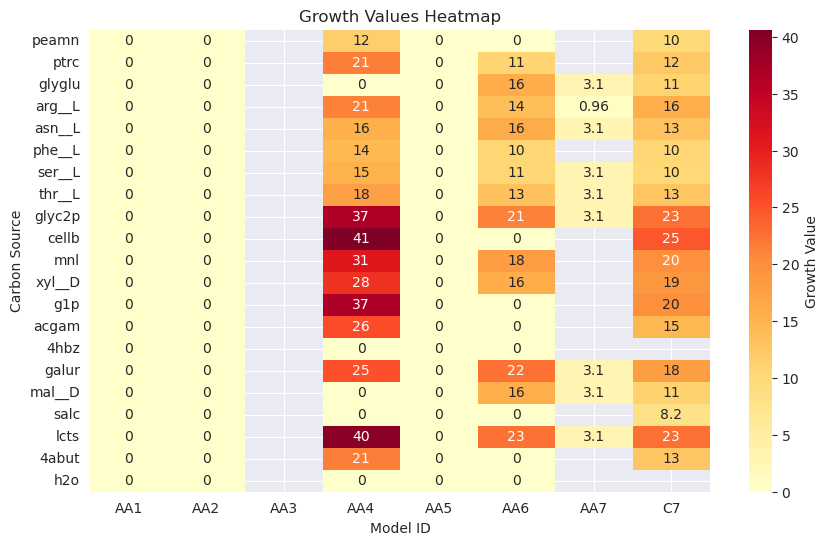

In [20]:
# AA7 is very sensitive to changes the bounds, it needs >500 to grow
create_medium(ecoplate_rxns, m9_rxn, all_models, 501)

EX_peamn_e Growth__AA1     0.000000
Growth__AA2     1.368356
Growth__AA3     0.000000
Growth__AA4    12.791489
Growth__AA5     0.000000
Growth__AA6    10.414244
Growth__AA7    12.136086
Name: fluxes, dtype: float64
EX_ptrc_e Growth__AA1     0.000000
Growth__AA2     0.000000
Growth__AA3     0.000000
Growth__AA4     7.135456
Growth__AA5     0.000000
Growth__AA6     1.046384
Growth__AA7    12.938315
Name: fluxes, dtype: float64
EX_glyglu_e Growth__AA1    0.000000e+00
Growth__AA2    4.598857e+00
Growth__AA3    2.487894e-10
Growth__AA4    7.103582e+00
Growth__AA5    0.000000e+00
Growth__AA6    2.016971e+00
Growth__AA7    1.212786e+01
Name: fluxes, dtype: float64
EX_arg__L_e Growth__AA1     0.000000
Growth__AA2     2.202917
Growth__AA3     0.000000
Growth__AA4     9.696806
Growth__AA5     0.000000
Growth__AA6     0.000000
Growth__AA7    11.732317
Name: fluxes, dtype: float64
EX_asn__L_e Growth__AA1    0.000000
Growth__AA2    0.000000
Growth__AA3    0.000000
Growth__AA4    0.000000
Growth__AA

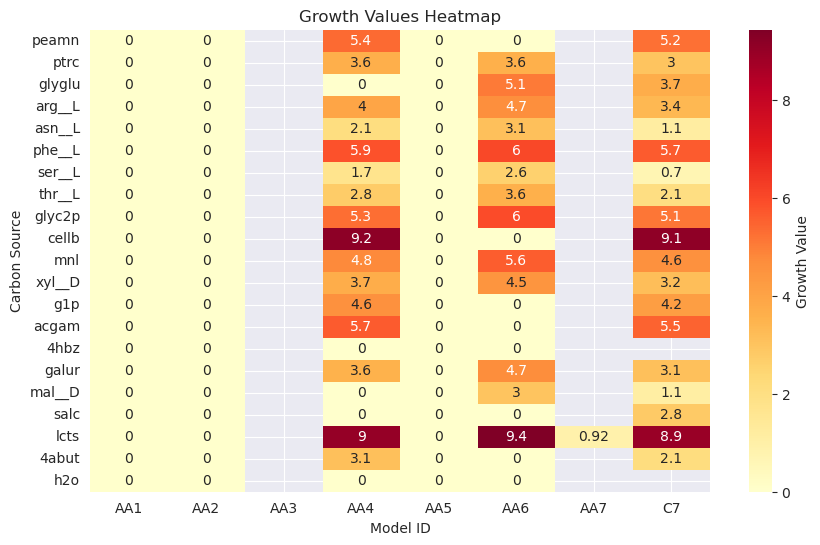

In [22]:
# all reactions in the M9 have a bound of 1000, only bounds of carbon reactions are modified
# AA7 can grow with carbon sources <500, i.e. especially O2 is limiting (i saw that in other simulations, that o2 ans fructose were the ones with highest flux values)
create_medium(ecoplate_rxns, m9_rxn, all_models, 45, carbon_only=True)

EX_peamn_e Growth__AA1     0.000000
Growth__AA2    16.773021
Growth__AA3     0.000000
Growth__AA4    15.688297
Growth__AA5     0.000000
Growth__AA6    24.317386
Growth__AA7    14.221310
Name: fluxes, dtype: float64
EX_ptrc_e Growth__AA1     0.000000
Growth__AA2    14.273917
Growth__AA3     0.401468
Growth__AA4    36.902476
Growth__AA5     0.000000
Growth__AA6    20.655448
Growth__AA7    13.565928
Name: fluxes, dtype: float64
EX_arg__L_e Growth__AA1     0.000000
Growth__AA2    18.950693
Growth__AA3     0.000000
Growth__AA4    55.697200
Growth__AA5     0.000000
Growth__AA6    19.115741
Growth__AA7    20.418680
Name: fluxes, dtype: float64
EX_asn__L_e Growth__AA1     0.000000
Growth__AA2    19.215322
Growth__AA3     6.183986
Growth__AA4    22.751540
Growth__AA5     0.000000
Growth__AA6    31.003917
Growth__AA7    12.978064
Name: fluxes, dtype: float64
EX_phe__L_e Growth__AA1     0.000000
Growth__AA2    15.205472
Growth__AA3     1.261184
Growth__AA4    19.396661
Growth__AA5     0.000000
Gr

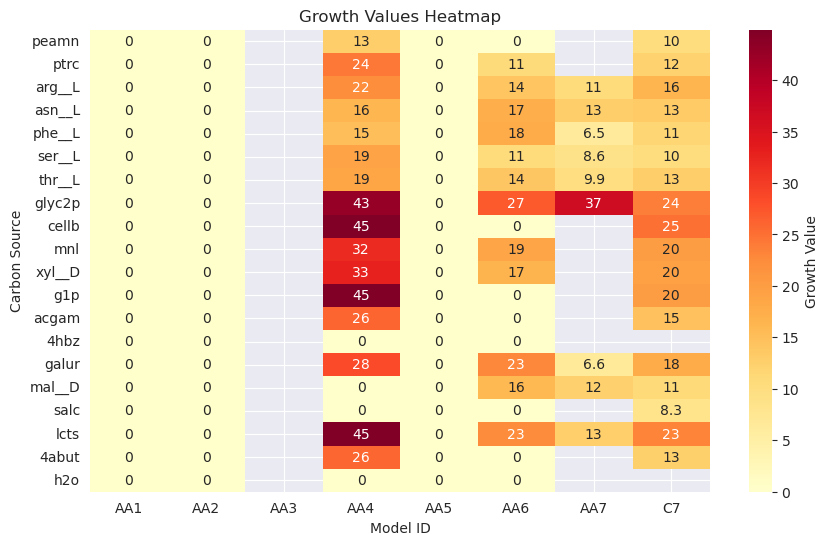

In [39]:
create_medium(ecoplate_rxns, m9_rxn, all_models, 1000)

EX_peamn_e Growth__AA1     0.000000
Growth__AA2    16.804976
Growth__AA3     0.000000
Growth__AA4    15.687307
Growth__AA5     0.000000
Growth__AA6    24.282321
Growth__AA7    14.222726
Name: fluxes, dtype: float64
EX_ptrc_e Growth__AA1     0.000000
Growth__AA2    14.273917
Growth__AA3     0.401464
Growth__AA4    36.901600
Growth__AA5     0.000000
Growth__AA6    20.655215
Growth__AA7    13.565935
Name: fluxes, dtype: float64
EX_glyglu_e Growth__AA1     0.000000
Growth__AA2    14.103643
Growth__AA3     0.284003
Growth__AA4    23.062361
Growth__AA5     0.000000
Growth__AA6    25.589343
Growth__AA7    13.382670
Name: fluxes, dtype: float64
EX_arg__L_e Growth__AA1     0.000000
Growth__AA2    18.950707
Growth__AA3     0.000000
Growth__AA4    55.695765
Growth__AA5     0.000000
Growth__AA6    19.115683
Growth__AA7    20.418685
Name: fluxes, dtype: float64
EX_asn__L_e Growth__AA1     0.000000
Growth__AA2    19.214802
Growth__AA3     6.183255
Growth__AA4    22.751532
Growth__AA5     0.000000
Gr

[06/24/25 10:02:23] WARNING  There does not seem to be any carbon source in your medium. Please    ]8;id=476225;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py\community.py]8;;\:]8;id=138412;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py#667\667]8;;\
                             double-check your medium IDs.                                                         

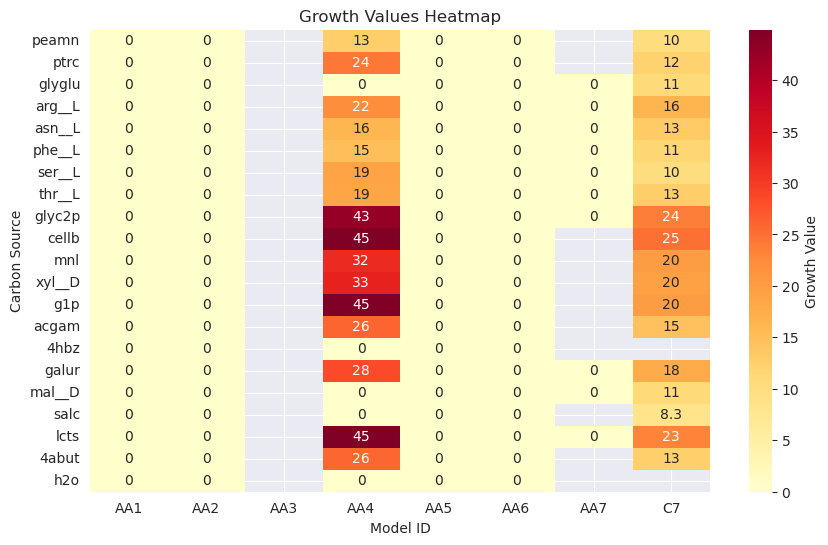

In [21]:
# without benzoate in medium
create_medium(ecoplate_rxns, m9_rxn[:-1], all_models, 1000)

## Aufnahme und Abgabe

In [30]:
def get_pfba_fluxes(model, medium):
    with model:
        change_medium(model, medium)
        pfba_fluxes = pfba(model).fluxes
        return pfba_fluxes

In [31]:
def compare_rxn_lists(com_index, single_index, model_id):
    # Convert to sets
    set1 = list(com_index)
    set2 = set(single_index)

    # Cut off the last 5 characters from each ID in list1
    set1 = set([rxn[:-5] for rxn in set1])

    # Reactions in both lists
    shared = set1 & set2  # or set1.intersection(set2)

    # unique reactions
    unique_to_list1 = set1 - set2
    unique_to_list2 = set2 - set1

    #print("Shared reactions:", sorted(shared))
    #print(f"Unique to Community-{model_id}:", sorted(unique_to_list1))
    #print(f"Unique to {model_id}:", sorted(unique_to_list2))

    return shared, unique_to_list1, unique_to_list2

In [32]:
def get_fluxes_for_heatmap(model, medium, type):
    fluxes = get_pfba_fluxes(model, medium)

    if type == "uptake":
        filtered_fluxes = fluxes[(fluxes.index.str.startswith('EX_')) &
                                 (fluxes < 0)]
    elif type == "secret":
        filtered_fluxes = fluxes[(fluxes.index.str.startswith('EX_')) &
                                 (fluxes > 0)]
    else:
        return "Specify either \"uptake\" or \"secret\" as type"

    if model.id == "C7":
        filtered_fluxes = filtered_fluxes[(filtered_fluxes.index.str.endswith('_m'))]

    flux_dict = {}
    for rxn_id, flux in filtered_fluxes.items():
        rxn = model.reactions.get_by_id(rxn_id)
        # Exchange reactions should have exactly one metabolite on one side
        met_id = list(rxn.metabolites.keys())[0].name  # us .id or use .name
        flux_dict[met_id] = flux

    #print(flux_dict.keys())
    return flux_dict

In [62]:
def uptake_secret_heatmap(all_models, type, initial_medium=None):
    data = {}

    for model_name, model_obj in all_models.items():
        if initial_medium is None:
            medium = minimal_medium(model_obj, 3)
            medium = medium.rename("bound").reset_index().rename(columns={"index": "reaction"})
            flux_dict = get_fluxes_for_heatmap(model_obj, medium, type)
        else:
            flux_dict = get_fluxes_for_heatmap(model_obj, initial_medium, type)
        data[model_name] = flux_dict  # keys: model names, values: dict of metabolite: flux

    df = pd.DataFrame(data).fillna(0)
    df = df.abs() # absolute values, so even negative fluxes have right colour scale that |-1000| is bigger than 0
    df = df.replace(0, np.nan)

    # Depending on Uptake or Secretion, choose different color scale
    color_map = {"uptake": "Blues", "secret": "Reds"}
    base_cmap_name = color_map[type]

    # Build custom colormap that starts with white
    base = sns.color_palette(base_cmap_name, 256).as_hex()
    custom_colors = ["#ffffff"] + base[1:]  # replace first entry with white
    custom_cmap = LinearSegmentedColormap.from_list(f"{base_cmap_name}_custom", custom_colors)

    # Plot heatmap
    plt.figure(figsize=(12, len(df) * 0.4))
    plt.grid(False)

    vmin = 1e-5  # threshold: if all flux values for a metabolite are below, they dont show up in the plot to not screw the color scale too much
    df_filtered = df[df.max(axis=1) >= vmin]

    ax = sns.heatmap(
        df_filtered,
        cmap=custom_cmap,
        norm=LogNorm(vmin=vmin, vmax=df_filtered.max().max()),
        cbar_kws={"label": "Flux (log scale)"},
        mask=df_filtered == 0,  # hide zero-flux cells
        linewidths=0.01,
        linecolor="whitesmoke"
    )

    # Clean up axes and background grid artifacts
    ax.set_facecolor("white")  # fill background of masked cells with white
    sns.despine(left=True, bottom=True)  # remove spines
    ax.tick_params(length=0)  # remove tick marks

    plt.title(f"{type.capitalize()} fluxes across models")
    plt.xlabel("Models")
    plt.ylabel(f"{type.capitalize()} reactions")
    plt.tight_layout()
    plt.show()

    """ without logarithmic scale
    # Plot heatmap
    plt.figure(figsize=(12, len(df) * 0.4))
    sns.heatmap(
        df,
        cmap=custom_cmap,
        vmin=0,  # ensures white is only used at exactly 0
        vmax=df.max().max(),  # max flux defines the top of the gradient
        linewidths=0.01,
        linecolor="whitesmoke",
        cbar_kws={"label": "Flux"}
    )
    plt.title(f"{type.capitalize()} fluxes across models")
    plt.xlabel("Models")
    plt.ylabel(f"{type.capitalize()} reactions")
    plt.tight_layout()
    plt.show()
    """

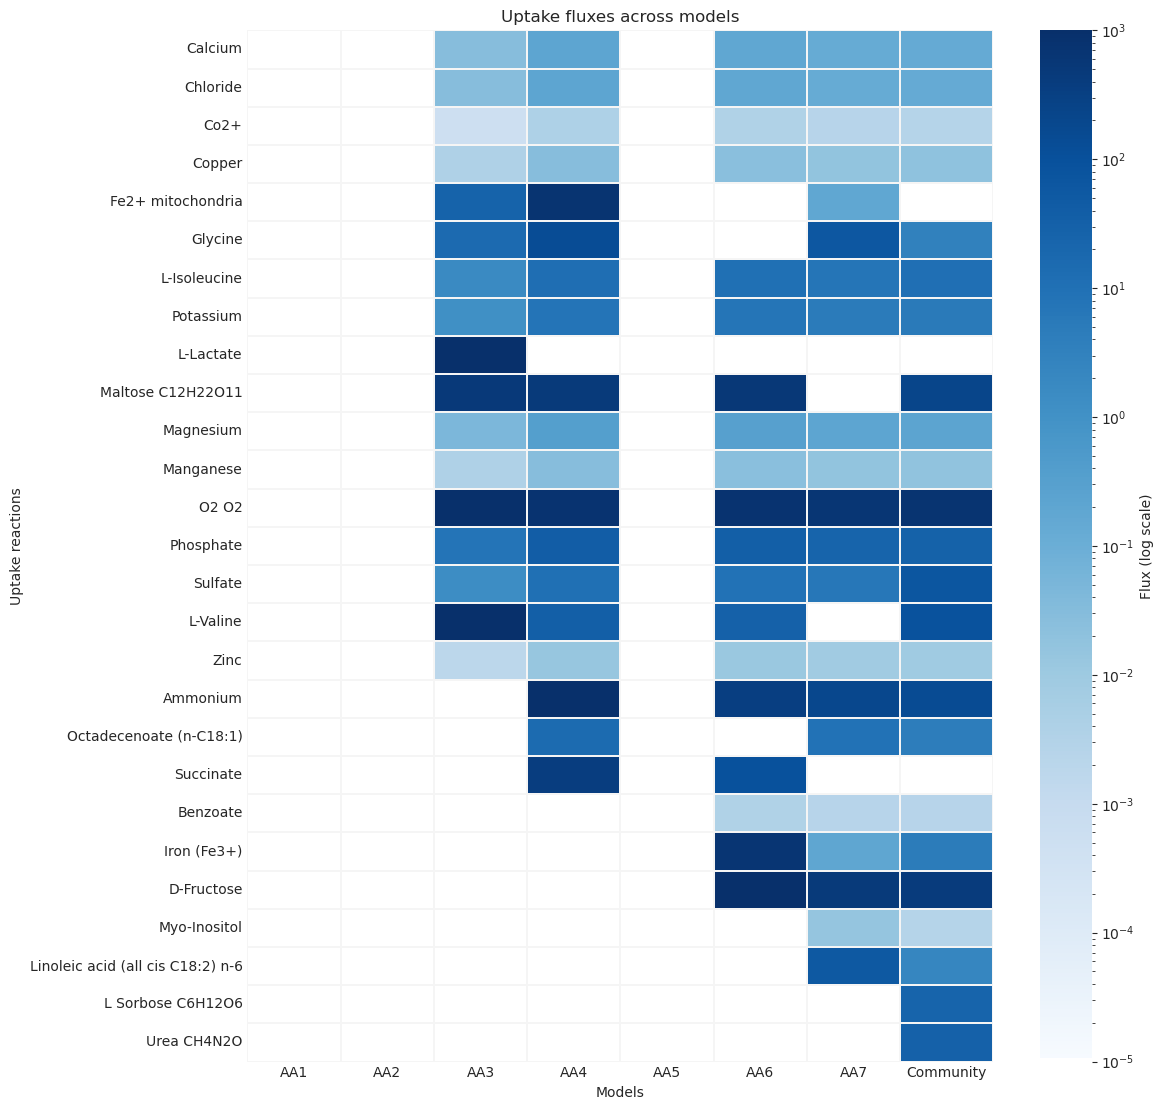

In [56]:
# the code for the community works in a way it only looks at EX reactions into/from the medium and outside and NO EX into/from a model into the medium
uptake_secret_heatmap(all_models, "uptake", medium_mre_m9)

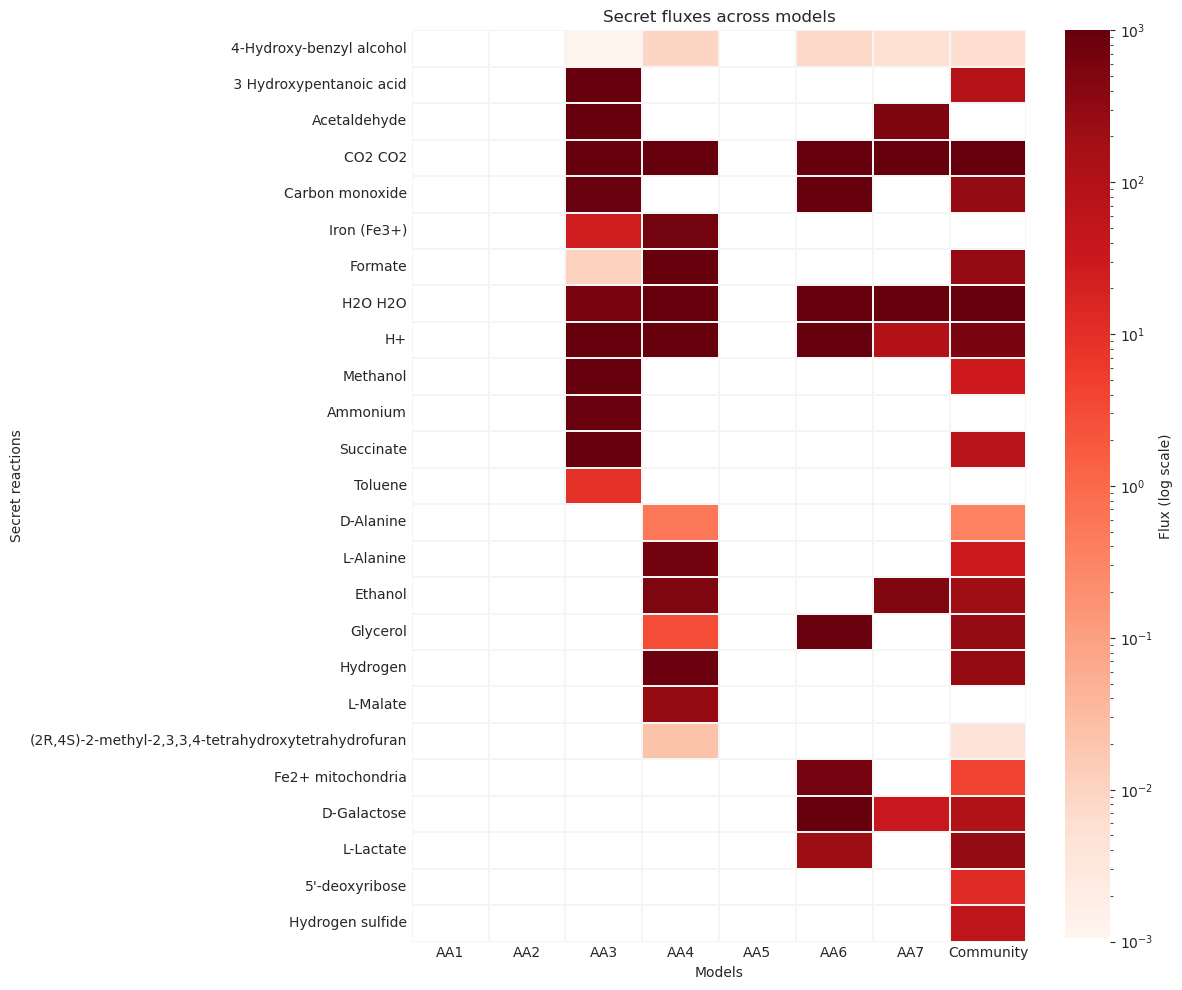

In [49]:
uptake_secret_heatmap(all_models, "secret", medium_mre_m9)

it may be interessting to see the metabolic niches of all my bacteria. but because some of them are not able to grow on their own, i would disregard the medium right now and maybe use the minimal medium for each of the bacteria determined by cobrapy.

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


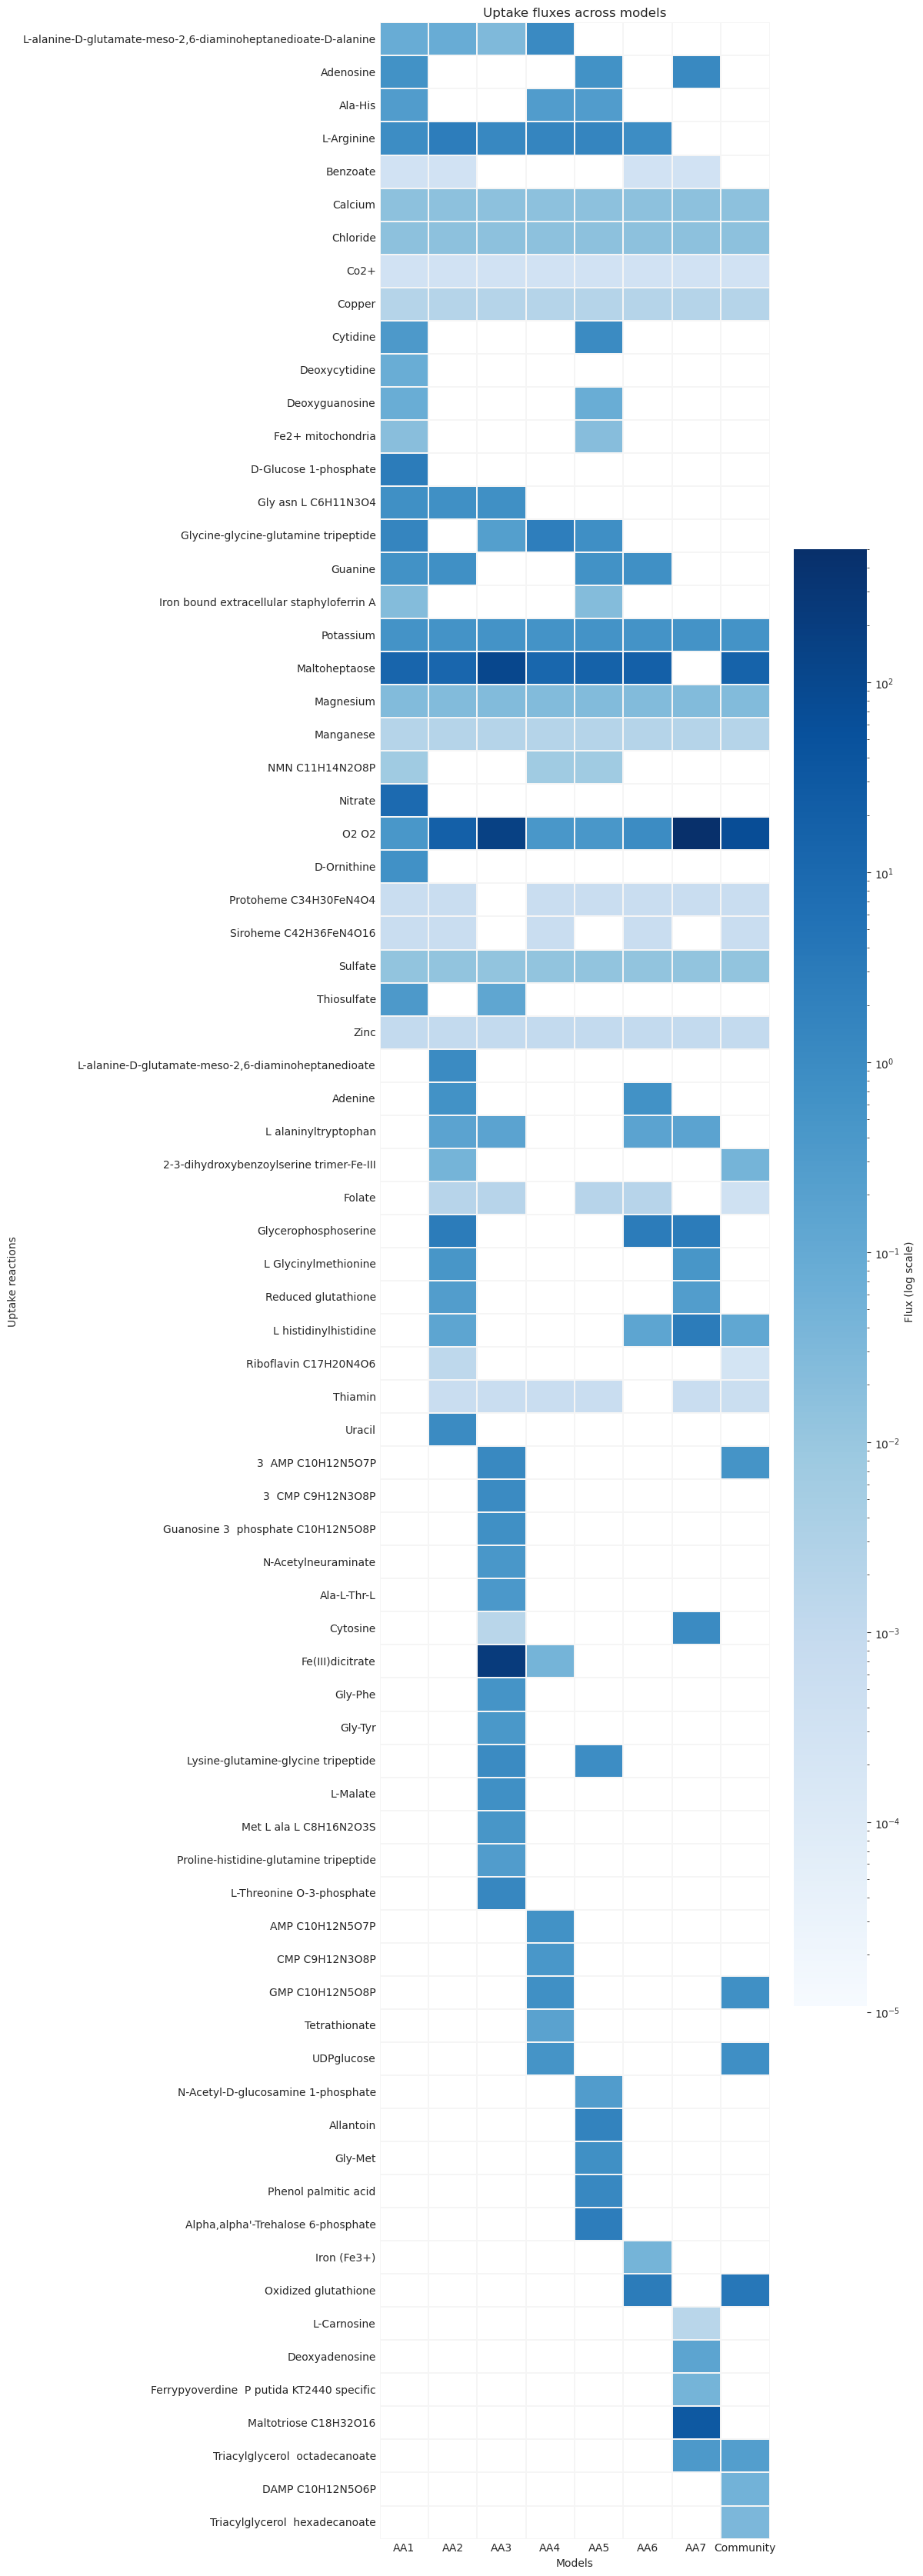

In [63]:
uptake_secret_heatmap(all_models, "uptake")

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


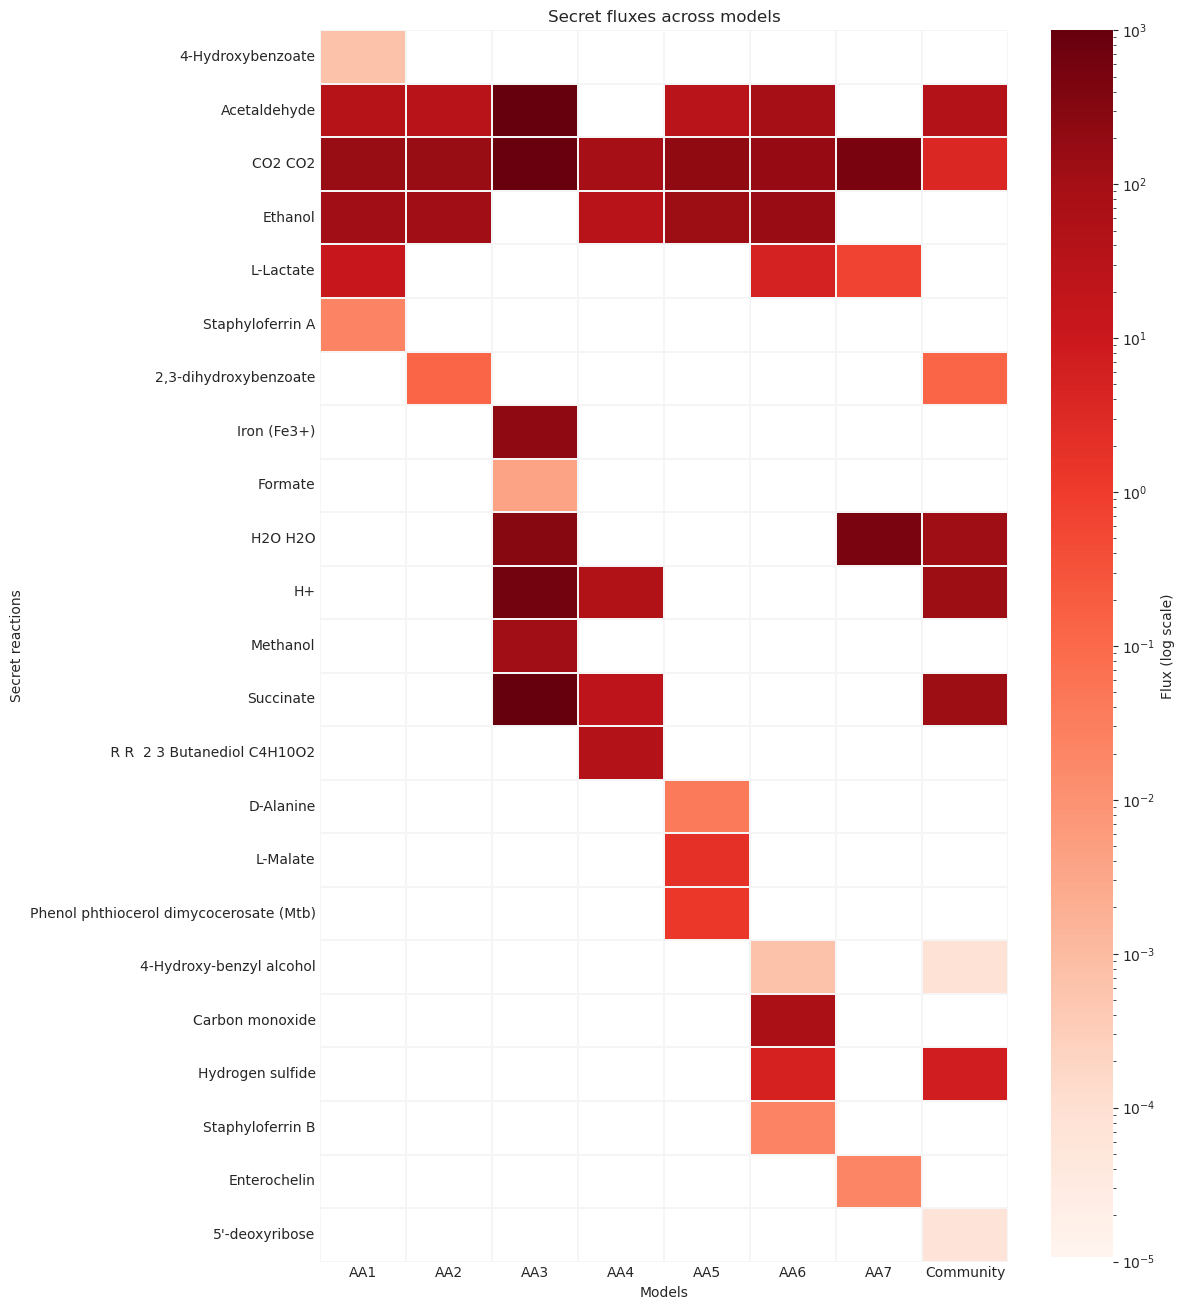

In [64]:
uptake_secret_heatmap(all_models, "secret")

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


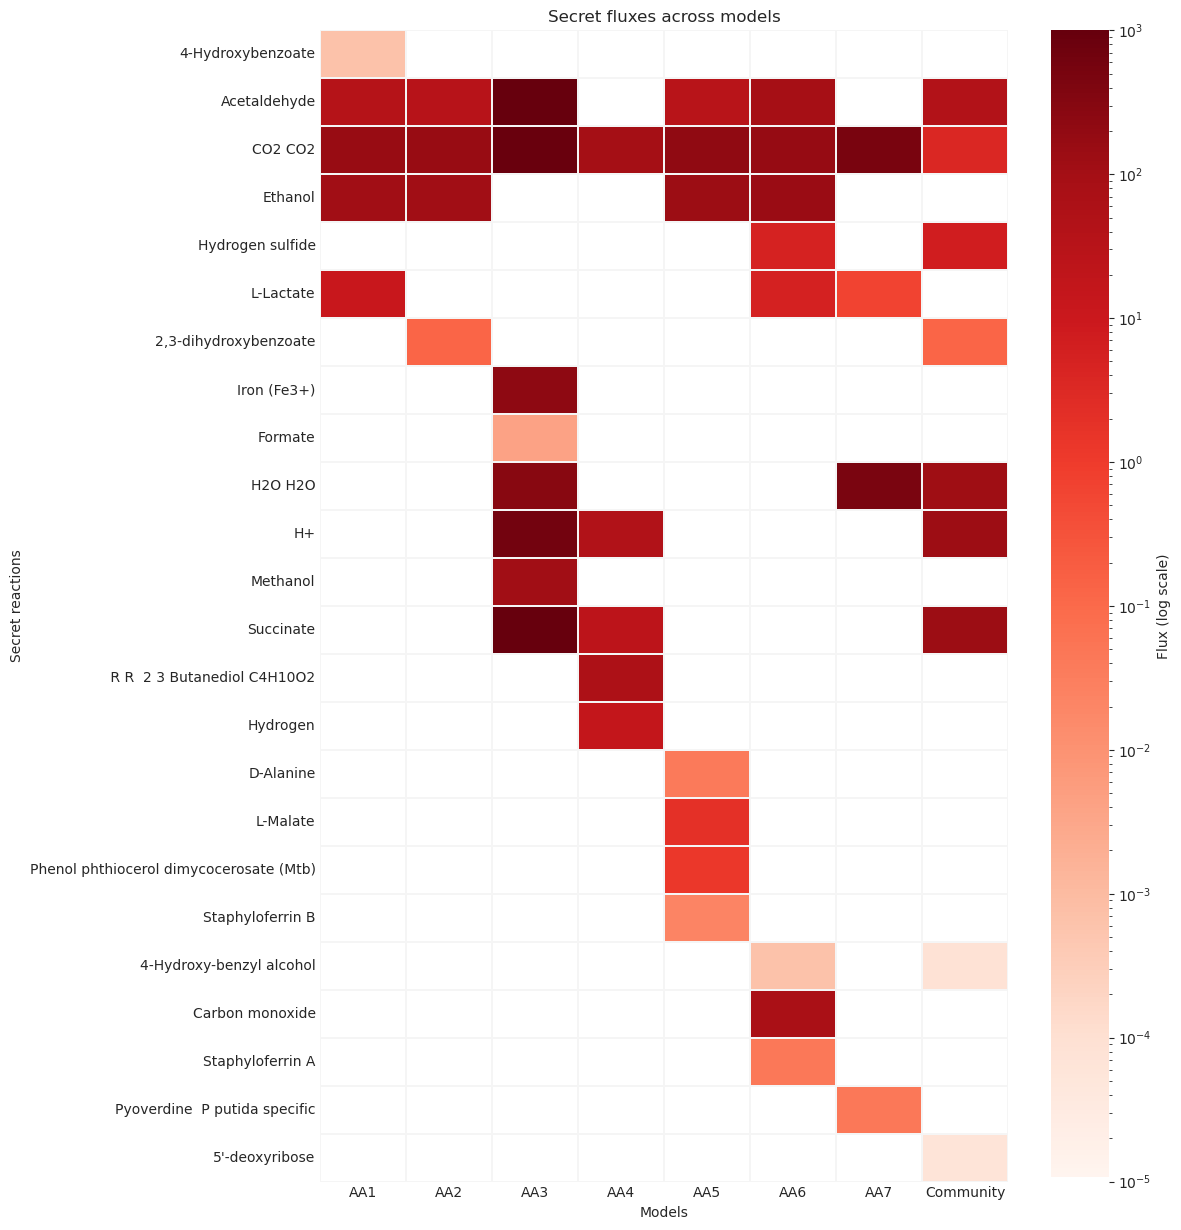

In [54]:
data = {}
type = "secret"
for model_name, model_obj in all_models.items():
    medium = minimal_medium(model_obj, 3)
    medium = medium.rename("bound").reset_index().rename(columns={"index": "reaction"})
    flux_dict = get_fluxes_for_heatmap(model_obj, medium, type)
    data[model_name] = flux_dict  # keys: model names, values: dict of metabolite: flux

df = pd.DataFrame(data).fillna(0)
df = df.abs() # absolute values, so even negative fluxes have right colour scale that |-1000| is bigger than 0
df = df.replace(0, np.nan)

# Depending on Uptake or Secretion, choose different color scale
color_map = {"uptake": "Blues", "secret": "Reds"}
base_cmap_name = color_map[type]

# Build custom colormap that starts with white
base = sns.color_palette(base_cmap_name, 256).as_hex()
custom_colors = ["#ffffff"] + base[1:]  # replace first entry with white
custom_cmap = LinearSegmentedColormap.from_list(f"{base_cmap_name}_custom", custom_colors)

# Plot heatmap
plt.figure(figsize=(12, len(df) * 0.4))
plt.grid(False)

vmin = 1e-5  # or whatever threshold you want
df_filtered = df[df.max(axis=1) >= vmin]


ax = sns.heatmap(
    df_filtered,
    cmap=custom_cmap,
    norm=LogNorm(vmin=vmin, vmax=df_filtered.max().max()),
    cbar_kws={"label": "Flux (log scale)"},
    mask=df_filtered == 0,  # hide zero-flux cells
    linewidths=0.01,
    linecolor="whitesmoke"
)

# Clean up axes and background grid artifacts
ax.set_facecolor("white")  # fill background of masked cells with white
sns.despine(left=True, bottom=True)  # remove spines
ax.tick_params(length=0)  # remove tick marks

plt.title(f"{type.capitalize()} fluxes across models")
plt.xlabel("Models")
plt.ylabel(f"{type.capitalize()} reactions")
plt.tight_layout()
plt.show()

Get the Uptakes and Secretion Fluxes more in detail; Comparison between individual model and their behaviour in the community

In [88]:
def get_uptake_secrets(model, medium, type):
    syncom_fluxes = get_pfba_fluxes(syncom, medium)
    single_flux = get_pfba_fluxes(model, medium)

    if type == "uptake":
        com_uptakes = syncom_fluxes[(syncom_fluxes.index.str.startswith('EX_')) &
                            (syncom_fluxes.index.str.endswith(f'_{model.id}')) &
                            (syncom_fluxes < 0)]
        single_uptakes = single_flux[(single_flux.index.str.startswith('EX_')) &
                        (single_flux < 0)]
    elif type == "secret":
        com_uptakes = syncom_fluxes[(syncom_fluxes.index.str.startswith('EX_')) &
                            (syncom_fluxes.index.str.endswith(f'_{model.id}')) &
                            (syncom_fluxes > 0)]
        single_uptakes = single_flux[(single_flux.index.str.startswith('EX_')) &
                        (single_flux > 0)]
    else:
        return "Specify either \"uptake\" or \"secret\" as type"

    shared, unique_to_com, unique_to_single = compare_rxn_lists(com_uptakes.index, single_uptakes.index, model.id)
    return shared, unique_to_com, unique_to_single


In [89]:
uptake_single, uptake_com, uptake_shared, secret_single, secret_com, secret_shared = [], [], [], [], [], []

for model in models.values():
    up_shared, up_unique_to_com, up_unique_to_single = get_uptake_secrets(model, medium_mre_m9, "uptake")
    uptake_single.append(up_unique_to_single)
    uptake_com.append(up_unique_to_com)
    uptake_shared.append(up_shared)

    sec_shared, sec_unique_to_com, sec_unique_to_single = get_uptake_secrets(model, medium_mre_m9, "secret")
    secret_single.append(sec_unique_to_single)
    secret_com.append(sec_unique_to_com)
    secret_shared.append(sec_shared)

# if Infeasible, change the bounds within the Community to 1000, see MICOM creation

In [90]:
labels = [f"AA{i}" for i in range(1, 8)]  # ['AA1', 'AA2', ..., 'AA7']
df_uptakes_secrets = pd.DataFrame({
    'model': labels,
    'uptake_single': uptake_single,
    'uptake_com': uptake_com,
    'uptake_shared': uptake_shared,
    'secret_single': secret_single,
    'secret_com': secret_com,
    'secret_shared': secret_shared
})

In [91]:
df_uptakes_secrets

,model,uptake_single,uptake_com,uptake_shared,secret_single,secret_com,secret_shared
0,AA1,{},"{EX_acald_e, EX_fru_e, EX_bz_e, EX_o2_e, EX_va...",{},{},"{EX_tol_e, EX_h_e, EX_glyc_e, EX_galct__D_e, E...",{}
1,AA2,{},"{EX_cys__L_e, EX_cobalt2_e, EX_fru_e, EX_mn2_e...",{},{},"{EX_val__L_e, EX_cgly_e, EX_glyc_e, EX_h2o_e, ...",{}
2,AA3,"{EX_gly_e, EX_lac__L_e, EX_pi_e, EX_ile__L_e}","{EX_trp__L_e, EX_cgly_e, EX_orn_e, EX_galur_e,...","{EX_o2_e, EX_ca2_e, EX_cobalt2_e, EX_val__L_e,...","{EX_tol_e, EX_fe3_e}","{EX_ala__D_e, EX_R_3httdca_e, EX_acglu_e, EX_g...","{EX_R_3hpt_e, EX_co_e, EX_acald_e, EX_h_e, EX_..."
3,AA4,{EX_nh4_e},"{EX_lys__L_e, EX_tol_e, EX_acglu_e, EX_gua_e, ...","{EX_o2_e, EX_cobalt2_e, EX_mn2_e, EX_ca2_e, EX...",{},"{EX_ppap_e, EX_cys__L_e, EX_tyr__L_e, EX_acald...","{EX_ala__D_e, EX_h_e, EX_for_e, EX_mththf_e, E..."
4,AA5,{},"{EX_acald_e, EX_o2_e, EX_gal_e, EX_glyc_e, EX_...",{},{},"{EX_lys__L_e, EX_etoh_e, EX_4abz_e, EX_pi_e, E...",{}
5,AA6,{EX_4hpro_LT_e},"{EX_lys__L_e, EX_cys__L_e, EX_acald_e, EX_R_3h...","{EX_o2_e, EX_cobalt2_e, EX_fru_e, EX_mn2_e, EX...",{},"{EX_galur_e, EX_s_e}","{EX_co_e, EX_h_e, EX_gal_e, EX_4hba_e, EX_glyc..."
6,AA7,"{EX_val__L_e, EX_nh4_e, EX_fe2_e}","{EX_lys__L_e, EX_cys__L_e, EX_tyr__L_e, EX_4ab...","{EX_o2_e, EX_cobalt2_e, EX_fru_e, EX_mn2_e, EX...","{EX_gal_e, EX_h_e}","{EX_ppap_e, EX_thm_e, EX_fe2_e, EX_orn_e, EX_n...","{EX_acald_e, EX_4hba_e, EX_h2o_e, EX_etoh_e, E..."


In [ ]:
from itertools import chain
# Flatten two levels: from list of sets to a single iterable of elements
unique_list = sorted(set(chain.from_iterable(chain.from_iterable([
    uptake_single, uptake_com, uptake_shared, secret_single, secret_com, secret_shared]))))
uptake_mets = sorted(set(chain.from_iterable(chain.from_iterable([
    uptake_single, uptake_com, uptake_shared]))))
secret_mets = sorted(set(chain.from_iterable(chain.from_iterable([
    secret_single, secret_com, secret_shared]))))
unique_mets = sorted(set(chain.from_iterable(chain.from_iterable([
    uptake_single, uptake_com, secret_single, secret_com]))))

# Spielplatz

checking orn and orn__D but adding a convert reaction in AA1 doesnt change anything i.e. AA1 is still not growing in the community (AA1 needs orn to grow and the other models mostly work with orn instead of orn__D like AA1)

In [104]:
exes = []
for model in all_models.values():
    exes.extend([(model.id, rxn.id) for rxn in model.reactions if rxn.id.startswith('EX_') and 'orn' in rxn.id])

In [105]:
exes

[('AA1', 'EX_orn__D_e'),
 ('AA1', 'EX_orn_e'),
 ('AA2', 'EX_orn_e'),
 ('AA3', 'EX_orn_e'),
 ('AA4', 'EX_orn_e'),
 ('AA5', 'EX_orn_e'),
 ('AA6', 'EX_orn_e'),
 ('AA7', 'EX_orn__D_e'),
 ('AA7', 'EX_orn_e'),
 ('C7', 'EX_orn__D_e__AA1'),
 ('C7', 'EX_orn_e__AA1'),
 ('C7', 'EX_orn__D_m'),
 ('C7', 'EX_orn_m'),
 ('C7', 'EX_orn_e__AA2'),
 ('C7', 'EX_orn_e__AA3'),
 ('C7', 'EX_orn_e__AA4'),
 ('C7', 'EX_orn_e__AA5'),
 ('C7', 'EX_orn_e__AA6'),
 ('C7', 'EX_orn__D_e__AA7'),
 ('C7', 'EX_orn_e__AA7')]

In [122]:
AA1.metabolites.orn__D_e

Metabolite identifier,orn__D_e
Name,D-Ornithine
Memory address,0x7a1a452e55a0
Formula,C5H13N2O2
Compartment,C_e
In 2 reaction(s),"DORNtex, EX_orn__D_e"


In [123]:
AA1.metabolites.orn_e

Metabolite identifier,orn_e
Name,Ornithine
Memory address,0x7a1a452e5ae0
Formula,C5H13N2O2
Compartment,C_e
In 2 reaction(s),"ORNt, EX_orn_e"


In [17]:
from cobra import Reaction

# Step 1: Create the reaction
new_rxn = Reaction('orn_transform')
new_rxn.name = 'Ornithine transformation'
new_rxn.lower_bound = -1000
new_rxn.upper_bound = 1000.0

# Step 2: Get the metabolite objects from the model
met1 = AA1.metabolites.get_by_id('orn__D_e')
met2 = AA1.metabolites.get_by_id('orn_e')

# Step 3: Add metabolites with stoichiometry
new_rxn.add_metabolites({
    met1: -1.0,
    met2: -1.0
})

# Step 4: Add the reaction to the model
AA1.add_reactions([new_rxn])

In [18]:
AA1.reactions.orn_transform

Reaction identifier,orn_transform
Name,Ornithine transformation
Memory address,0x71f329e1d0c0
Stoichiometry,orn__D_e + orn_e <=> D-Ornithine + Ornithine <=>
GPR,
Lower bound,-1000
Upper bound,1000.0


In [19]:
growth_val = test_medium(AA1, medium_mre_m9)
print(growth_val)

0.0


In [51]:
rxns = syncom.reactions

In [ ]:
# get minimal media so everybody in communtiy can grow

In [ ]:
from micom.workflows import complete_community_medium

medium = complete_community_medium(manifest, model_folder="../", medium=medium_mre_m9,
                    community_growth=0.1, min_growth=0.01,
                    max_import=10, threads=2)

In [118]:
og_medium = pd.read_csv("../krumbach_og_medium.csv", sep=";", header=None)

In [125]:
len(set(og_medium[0]))

259

In [126]:
set(og_medium[0])

{'(+/-)-Isobutyl 3-methylthiobutyrate',
 '(3R,5S,6E)-rel-7-[3-(4-fluorophenyl)-1H-indol-2-yl]-3,5-dihydroxy-6-Heptenoic acid',
 '(E)-2-Methylglutaconic acid',
 '(R)-2-Hydroxy-7,8-dimethoxy-2H-1,4-benzoxazin-3(4H)-one 2-glucoside',
 '(R)-Ureidoglycolate',
 '(S)-(-)-2-Hydroxyisocaproic acid',
 '(S)-2-Hydroxypropylphosphonate',
 '(±)-Flufenprox',
 '-',
 '1,1-Cyclopropanedicarboxylic acid',
 '1-(3-Carboxypropyl)-3,7-dimethylxanthine',
 '1-L-Leucyl-L-Proline',
 '1-O-Sinapoyl-beta-D-glucose',
 '10,11-epoxy-chlorovulone I',
 '10-Deoxygeniposidic acid',
 "13-Hydroxy-5'-O-methylmelledonal",
 "2'-Deoxyadenosine",
 "2'-Deoxymugineic acid",
 '2,3-Butanediol glucoside',
 '2,4-Dichlorophenoxyacetic Acid, Isooctyl Ester',
 '2,4-Dihydroxy-7,8-dimethoxy-2H-1,4-benzoxazin-3(4H)-one 2-glucoside',
 '2,5-Furandicarboxylic acid',
 '2,6-Diamino-4-hydroxy-5-N-methylformamidopyrimidine',
 '2-(4-Methyl-5-thiazolyl)ethyl octanoate',
 '2-(Acetamidomethylene)succinate',
 '2-Aminomuconate 6-semialdehyde',
 '2-Benzo